# Image Classification Data Preprocessing

In this notebook we will:
1. Load our dataset of animal images 
2. Preprocess the images by resizing and normalizing
3. Apply data augmentation techniques
4. Visualize some sample images along with their labels
5. Check for class balance and plan strategies to handle imbalanced data if needed.
6. Save the rebalanced Training Dataset to TFRecord

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os


# Define dataset directory 
dataset_dir = r"..\data\raw\raw-img" 

# Set parameters for image dimensions and batch size
img_height = 150
img_width = 150
batch_size = 32

In [2]:
# Load the dataset using image_dataset_from_directory
# validation split to later create a training and validation set.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names for future reference
class_names = train_ds.class_names
print("Class names:", class_names)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [3]:
# Data Normalization: Scale pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to training and validation datasets
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Data Augmentation: Define augmentation steps (flip, rotation)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
    # add more augmentation layers if needed
])


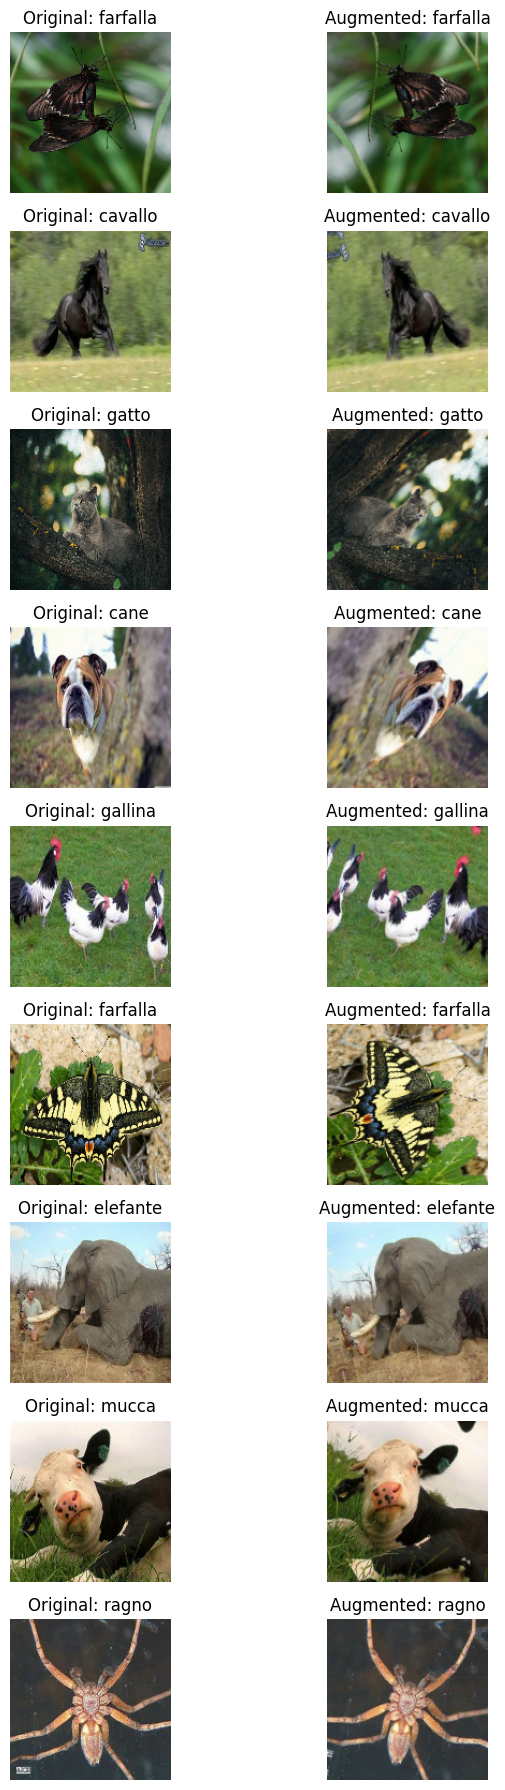

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Number of image pairs to display
num_examples = 9

# Retrieve one batch from the normalized training dataset
for images, labels in normalized_train_ds.take(1):
    # Generate augmented images from the original batch
    augmented_images = data_augmentation(images)
    
    # Create a figure with 9 rows and 2 columns
    plt.figure(figsize=(8, 18))
    for i in range(num_examples):
        # Original image on the left
        ax = plt.subplot(num_examples, 2, 2*i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Original: " + class_names[labels[i]])
        plt.axis("off")
        
        # Augmented image on the right
        ax = plt.subplot(num_examples, 2, 2*i + 2)
        plt.imshow(augmented_images[i].numpy())
        plt.title("Augmented: " + class_names[labels[i]])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


## Class Distribution Analysis
Check for class balance


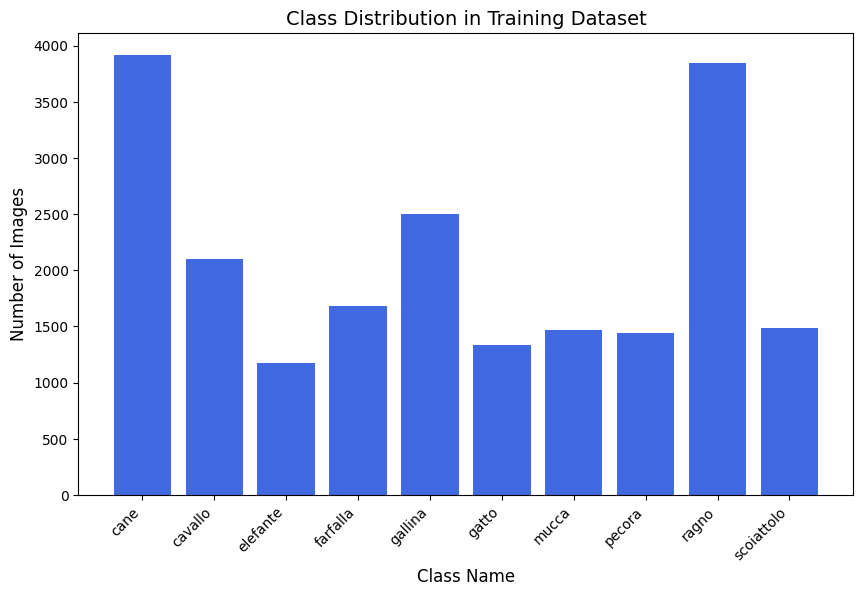

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import collections

# Retrieve class names from dataset
class_names = train_ds.class_names

# Initialize a dictionary to store class counts
class_counts = collections.defaultdict(int)

# Count occurrences of each class in the dataset
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Convert dictionary to sorted lists for plotting
classes, counts = zip(*sorted(class_counts.items()))

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='royalblue')
plt.xlabel("Class Name", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution in Training Dataset", fontsize=14)
plt.show()


the dataset has significant class imbalance.

Rebalancing strategy:

Apply more aggressive augmentation only to underrepresented classes (elephant, butterfly, etc.).

Use random transformations like:
    Horizontal flips
    Random rotations
    Zooming
    Brightness/contrast adjustments

Create a custom data pipeline where augmentation is applied differently per class.

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Identify minority classes:
minority_class_names = ["elefante", "farfalla"]

# Convert these class names to their numeric label indices
minority_indices_list = [class_names.index(cname) for cname in minority_class_names]

# Define minority_indices as int32 to match dataset labels
minority_indices = tf.constant(minority_indices_list, dtype=tf.int32)
print("Minority indices:", minority_indices.numpy())

Minority indices: [2 3]


In [7]:
# More aggressive augmentation layers
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

def conditional_augment(images, labels):
    """
    images: [batch, height, width, channels]
    labels: [batch] (each element is an integer class index)
    """
    # Compare labels with minority_indices -> shape [batch, #minority_classes]
    # e.g., each label is compared to [2, 3] if 'elefante'=2, 'farfalla'=3
    expanded_labels = tf.expand_dims(labels, axis=-1)   # shape [batch, 1]
    comparisons = tf.equal(expanded_labels, minority_indices)  # shape [batch, #minority_classes]

    # True if label matches ANY minority index
    mask = tf.reduce_any(comparisons, axis=1)  # shape [batch]

    # Apply augmentation to the entire batch first
    augmented_images = augmentation_layers(images)

    # Now choose augmented_images only where mask is True
    # Reshape mask to broadcast over [batch, height, width, channels]
    mask_4d = tf.reshape(mask, [-1, 1, 1, 1])

    # Where mask is True, use augmented_images, else use original
    final_images = tf.where(mask_4d, augmented_images, images)

    return final_images, labels

balanced_train_ds = train_ds.map(conditional_augment)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..251.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5599823..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.29898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [20.545021..255.0].
Clipping input data to the valid range for ims

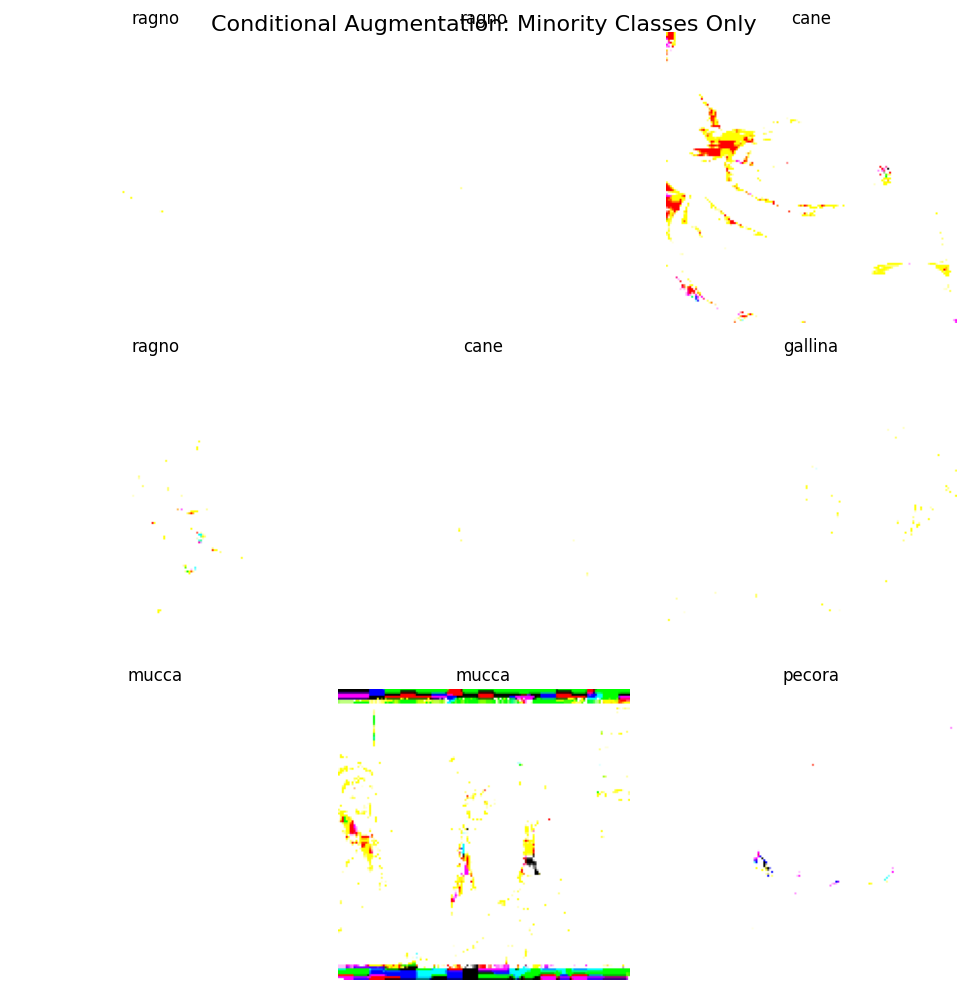

In [8]:
import matplotlib.pyplot as plt

# Take one batch from the balanced dataset
for batch_images, batch_labels in balanced_train_ds.take(1):
    # Convert to numpy for plotting
    images_np = batch_images.numpy()
    labels_np = batch_labels.numpy()
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_np[i])
        plt.title(class_names[labels_np[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.suptitle("Conditional Augmentation: Minority Classes Only", fontsize=16)
    plt.show()
    break


In [9]:
import tensorflow as tf

# Load the entire dataset without an explicit split
all_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

# Determine the number of batches in the dataset
total_batches = tf.data.experimental.cardinality(all_ds).numpy()
print("Total batches:", total_batches)

# Define splits: 70% training, 15% validation, 15% testing.
train_batches = int(0.7 * total_batches)
val_batches = int(0.15 * total_batches)
test_batches = total_batches - train_batches - val_batches
print("Train batches:", train_batches, "Val batches:", val_batches, "Test batches:", test_batches)

# Split the dataset
train_ds = all_ds.take(train_batches)
remaining = all_ds.skip(train_batches)
val_ds = remaining.take(val_batches)
test_ds = remaining.skip(val_batches)

# Performance improvements: cache and prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Train dataset batches (original):", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation dataset batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test dataset batches:", tf.data.experimental.cardinality(test_ds).numpy())

# ----- Rebalancing Adjustments -----
class_names = all_ds.class_names
print("Class names:", class_names)


# Convert minority class names to numeric indices; ensure types match (tf.int32)
minority_indices = tf.constant([class_names.index(cname) for cname in minority_class_names], dtype=tf.int32)
print("Minority indices:", minority_indices.numpy())

# Define more aggressive augmentation layers
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

def conditional_augment(images, labels):
    """
    images: Tensor of shape [batch, height, width, channels]
    labels: Tensor of shape [batch], with integer class indices
    """
    # Expand labels to shape [batch, 1] to compare against minority indices.
    expanded_labels = tf.expand_dims(labels, axis=-1)  # shape: [batch, 1]
    
    # Compare each label against each minority index; result is shape [batch, num_minority_classes]
    comparisons = tf.equal(expanded_labels, minority_indices)
    
    # Create a boolean mask: True if a sample belongs to any minority class
    mask = tf.reduce_any(comparisons, axis=1)  # shape: [batch]
    
    # Apply augmentation to the entire batch first
    augmented_images = augmentation_layers(images)
    
    # Reshape mask for broadcasting over image dimensions: [batch, 1, 1, 1]
    mask_4d = tf.reshape(mask, [-1, 1, 1, 1])
    
    # Use augmented images where mask is True, otherwise use original images
    final_images = tf.where(mask_4d, augmented_images, images)
    
    return final_images, labels

# Apply conditional augmentation (rebalancing) only to the training dataset
train_ds_rebalanced = train_ds.map(conditional_augment)

# Verify the new training set (the number of batches remains the same)
print("Train dataset batches (rebalanced):", tf.data.experimental.cardinality(train_ds_rebalanced).numpy())


Found 26179 files belonging to 10 classes.
Total batches: 819
Train batches: 573 Val batches: 122 Test batches: 124
Train dataset batches (original): 573
Validation dataset batches: 122
Test dataset batches: 124
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Minority indices: [2 3]
Train dataset batches (rebalanced): 573


### Saving the Rebalanced Training Dataset to TFRecord

After applying conditional augmentation to rebalance the dataset, we need to save the rebalanced training dataset for future use. TFRecord is an efficient binary format that allows for optimized storage and loading in TensorFlow.

#### **Steps in this cell:**
1. **Define helper functions** to convert images and labels into the TFRecord format.
2. **Serialize each image-label pair** by encoding images as JPEG and converting labels to integer format.
3. **Write the rebalanced dataset to a `.tfrecord` file** using `tf.io.TFRecordWriter`.

#### **Why use TFRecord?**
- Efficient storage for large datasets.
- Faster loading compared to individual image files.
- Allows for streamlined data pipeline integration with TensorFlow.

In [ ]:
import tensorflow as tf
import datetime

# Helper functions to create TFRecord features
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # Convert an EagerTensor to bytes.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from an int."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Ensure the image is in uint8 format (e.g., [0,255] range)
    image = tf.cast(image, tf.uint8)
    # Encode the image as JPEG (this produces a byte string)
    image_encoded = tf.io.encode_jpeg(image).numpy()
    
    feature = {
        'image': _bytes_feature(image_encoded),
        'label': _int64_feature(label)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Define the TFRecord filename, including a timestamp

# Generate timestamp for filename
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Specify the TFRecord filename with timestamp
tfrecord_filename = f"balanced_train_{timestamp}.tfrecord"

# Write the rebalanced dataset to TFRecord
with tf.io.TFRecordWriter(tfrecord_filename) as writer:
    # Loop over the rebalanced training dataset
    for images, labels in train_ds_rebalanced:
        # Loop over each sample in the batch
        for i in range(images.shape[0]):
            serialized_example = serialize_example(images[i], int(labels[i]))
            writer.write(serialized_example)

print("TFRecord file saved as:", tfrecord_filename)

TFRecord file saved as: balanced_train_20250218_231144.tfrecord


In [11]:
import datetime
import tensorflow as tf

# Helper functions (if not already defined)
def _bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # Convert EagerTensor to bytes if necessary
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from an int."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    Assumes image is already resized (e.g. 150x150) and optionally normalized.
    """
    # Cast image to uint8 and encode as JPEG
    image = tf.cast(image, tf.uint8)
    image_encoded = tf.io.encode_jpeg(image).numpy()
    feature = {
        'image': _bytes_feature(image_encoded),
        'label': _int64_feature(label)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Generate a timestamp for unique filenames
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the Validation Set
val_tfrecord_filename = f"balanced_val_{timestamp}.tfrecord"
with tf.io.TFRecordWriter(val_tfrecord_filename) as writer:
    for images, labels in val_ds:  # Assuming 'val_ds' is your validation dataset
        for i in range(images.shape[0]):
            serialized_example = serialize_example(images[i], int(labels[i]))
            writer.write(serialized_example)
print("Validation TFRecord saved as:", val_tfrecord_filename)

# Save the Testing Set
test_tfrecord_filename = f"balanced_test_{timestamp}.tfrecord"
with tf.io.TFRecordWriter(test_tfrecord_filename) as writer:
    for images, labels in test_ds:  # Assuming 'test_ds' is your testing dataset
        for i in range(images.shape[0]):
            serialized_example = serialize_example(images[i], int(labels[i]))
            writer.write(serialized_example)
print("Test TFRecord saved as:", test_tfrecord_filename)


Validation TFRecord saved as: balanced_val_20250220_235108.tfrecord
Test TFRecord saved as: balanced_test_20250220_235108.tfrecord
